## Table of Contents
1. [Introduction](#intro)  
    1.1. [Background](#intro/background)  
    1.2. [Problem Statement](#intro/problem)  
    1.3. [Abstract](#intro/abstract)  
    1.4. [Packages](#intro/packages)    
2. [Data](#data)      
    2.1. [About the Data](#data/about)   
    2.2. [Collection](#data/collection)   
    2.3. [Pre-Processing](#data/processing)  
    2.4. [Variables](#data/variables)  
3. [Exploratory Data Analysis](#EDA)     
    3.1. [Target Variable: Sale Price](#EDA/target)  
    3.2. [Testing Assumptions of Linear Regression](#EDA/assumptions)  
    3.3. [Correlations](#EDA/correlations)  
    3.4. [Omitting Bias](#EDA/bias)  
4. [Modeling](#modeling)   
    4.1. [Model Creation](#modeling/construction)    
    4.2. [Model Selection](#modeling/selection)   
    4.3. [Model Validation](#modeling/validation)     
5. [Conclusion](#conclusion)   
    5.1. [Primary Findings](#conclusion/findings)   
    5.2. [Potential Areas for Improvement](#conclusion/improvement)   
    5.3. [Reflection](#conclusion/reflection)   
6. [References & Resources](#references)

<a id="intro"></a>
## 1. Introduction

n.b. This is WIP. 

<a id="intro/background"></a>
### 1.1.  Background

In 2018, there were Cornell 15,000 students living off campus in Tompkins County. 
the vacancy rate remains well below average. Forcing students to sign leases often 2+ years out. 

Cornell guarantees housing only to its Freshman and Sophomore students. 
   
Students are paying a premium for lower quality housing

Attempts to increase housing supply 

“The New York Times article that just came out that looked at all of these market areas had, to me, really surprising results,” said Paul Mazzarella, Executive Director of Ithaca Neighborhood Housing Services (INHS). “I knew Ithaca was expensive. I’ve also known New York City was very expensive. One of things that makes rentals expensive in Ithaca is that the supply of rental units is really limited.”


<img src="assets/rents-by-school.png"  width="700" align="left"/>    


<a id="intro/problem"></a>
### 1.2. Problem Statement

With limited supply, often wealthy renters, and highly variable geography, it is clear that the collegetown rental market is unique. Students often consider distance to campus, ease of walking, proximity to useful bus stops and popular social locations when looking at potential housing. Within such a market, how do Cornell students actually value collegetown rentals? Is it possible to isolate the factors that actually drive prices, and help Cornell students find value relative to their living preferences? 

<a id="intro/abstract"></a>
### 1.3. Abstract
Project finds that exploratory analysis,
Mutilvariate regression modeling. 
Hedonic pric

In [7]:
#import above packages
import pandas as pd
import numpy as np
import folium 
from scipy import stats
from scipy.stats import norm, skew 
import requests
import json
import math
import time
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
import matplotlib.style as style
style.use('fivethirtyeight')
from math import radians, cos, sin, asin, sqrt
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf


<a id="data"></a>
## 2. Data

<a id="data/about"></a>
### 2.1. About the Dataset
The Cornell University Office of Off-Campus Living maintains a pubically-accessible [database of rental listings]( https://listings.offcampusliving.cornell.edu). 

Database Curators Contact Information:  
>Office of Off-Campus Living  
531 Willard Straight Hall   
Ithaca, New York 14891
(607) 254-8383  
offcampusliving@cornell.edu. 

The database allows users to filter by the following: 
> - Price (0-5000 USD)
> - Number of Bedrooms (0-10+) 
> - Pets Allowed? (Yes, No)
> - Listing Type (Any, Commencement, Fall Sublet, Graduate, Sabbatic Housing, Short-Term Housing, Spring Sublet, Staff/Faculty, Summer Sublet, Undergradate)
> - Housing Type (Rent, Room to Rent, Share)
> - Date Availible (MM-DD-YYYY)

And provides information about each individual listing under the following conventions:   
> - Address
> - Topline Description
> - Extended Description
> - Number of Bedrooms
> - Number of Bathrooms
> - Pets Allowed (yes,no)
> - Housing Type (Rent, Room to Rent, Share)
> - Listing Type (Any, Commencement, Fall Sublet, Graduate, Sabbatic Housing, Short-Term Housing, Spring Sublet, Staff/Faculty, Summer Sublet, Undergradate)
> - Rent (price per unit in USD)
> - Date Availible
> - Amenities
>       - Air Conditioning
>       - Electricity Included
>       - Electronic Payments Accepted
>       - Furnished
>       - Heat Included
>       - Internet Included
>       - Kitchen
>       - Laundry Facilities
>       - Near Bus Route
>       - Off-Street Parking Available
>       - Off-Street Parking Included
>       - Permitted Street Parking Available 
>       - Water Included
> n.b. Information related to safety standards is provided, but only for a limited number of listings and as often incomplete. For the purposes of this project, it will be ignored. 


On their [website](https://scl.cornell.edu/residential-life/housing/campus-living/landlords), The Office of Off-Campus Living offers the following information:

>Our office, in conjunction with the Student Services IT (Information Technology) department, has worked to create an entirely new listing database with great features. Notice: Properties within the City of Ithaca must have a current Certificate of Compliance with the City of Ithaca Building Department to post your listing. The system is set up to only allow listings to be paid for up the expiration date of the COC. Unlike the old system, listings do not require administrative approval to go live as the COC check is now fully automated. Listings will be searchable once they are paid for and made active by the landlord. 
> - New dynamic search pages via Google Map search or criteria search  
> - Increased security-viewers will not see contact information (email or phone) without first authenticating a Cornell University relationship 
> - Automated Certification of Compliance verification for properties within the City of Ithaca 
> - Photos and Images 
> - Multiple photos can be added to your listing 
> - Listings can be extended from 1 to 12 months (properties within the city cannot be extended past the month the COC expires.) 
> - Listings are one flat rate of 30 USD per month
> - The System has been designed to be-compatible with all major browsers and operating systems on computers, tablet and smartphones 
> - Manage your listings  
> - Activate/Inactivate
> - Verify and update Google Map location 
> - Reactivate expired listings 
> - Update property photos


**Why use this data?**    
Regression analysis often noisy and subject to error. By using a dataset of listings specifically targeted to Cornell Students, the dataset offers a useful proxy for the Cornell specific market which this project hopes to analyze. In theory, this reduces the noise associated with listings outside, and allows for a better understanding of what Cornell students for in rental housing.   

In [8]:
def extract(url="https://listings.offcampusliving.cornell.edu/api/listing/", start=1, end=10, wait=0.01):
    """
    Sends GET request to Off-Campus Listing Database, parses JSON, and returns DataFrame with non-null rows. 
    
    param start: int 
    param end: int
    param wait: float
    rtype: pd.DataFrame 
    """
    entries = []
    for i in range(start,end+1):
        response = requests.get(url+str(i))
        listing_json = response.json()
        if listing_json is not None:
            entries.append(listing_json[0])
        time.sleep(wait)
    return pd.DataFrame(entries)

In [99]:
# Save as CSV
#df = extract(end=3614)
df.to_csv("raw_scrape_oct_25_2021.csv")

In [9]:
def load_data(filepath="data/raw_scrape_oct_25_2021.csv"):  
    """
    param filepath: str of filename (including '.csv')
    rtype: pd.DataFrame
    """
    df = pd.read_csv(filepath)
    return df

In [11]:
load_data().rentType.value_counts()

rentType
Price per Unit      2104
Price per Person    1453
Name: count, dtype: int64

<a id="data/processing"></a>
### 2.3. Pre-Processing

### Adding Columns

In [12]:
# Using haversine function, google map data to compute a distance to McGraw Clocktower (a proxy for campus)
# for each of these listings, we want to compute the haversine dist from the listing to the clocktower. 
# haversine code from police allocation activity. 
def haversine_distance(pt1, pt2):
    """
    type pt1: tuple 
    type pt2: tuple
    rtype: float (m)
    """
    lat1,lon1 = pt1
    lat2,lon2 = pt2
    # convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    # haversine formula
    a = sin((lat2 - lat1)/2)**2 + cos(lat1) * cos(lat2) * sin((lon2 - lon1)/2)**2
    c = 2 * asin(sqrt(a))
    return float(6371000*c)

In [13]:
# McGraw Clocktower (lat,long): 42.44764589643703, -76.48496728637923
def add_distance_to_campus(df, lat=42.44764589643703, long=-76.48496728637923): 
    """
    Uses haversine_distance to calculate and record distance_to_campus (in meters) for each listing in DataFrame
    """
    distances = []
    for index, row in df.iterrows(): 
        listing_latitude = row["gmapLatitude"]
        listing_longitude = row["gmapLongitude"]
        distances.append((haversine_distance((listing_latitude,listing_longitude),((lat,long)))))
    df["distance_to_campus"] = distances
    df["distance_to_campus"] = df["distance_to_campus"].astype(float)
    return df

In [14]:
def add_price_per_room(df):
    """
    """
    df["price_per_room"] = df.apply(lambda row: row.rentAmount/(row.bedrooms+1) if row.rentType == "Price per Unit" else row.rentAmount, axis=1)
    return df 

In [15]:
load_data().rentType.value_counts()

rentType
Price per Unit      2104
Price per Person    1453
Name: count, dtype: int64

In [16]:
def add_price_per_unit(df):
    """
    """
    df["price_per_unit"] = df.apply(lambda row: row.rentAmount*(row.bedrooms+1) if row.rentType == "Price per Person" else row.rentAmount, axis=1)
    return df

In [17]:
def convert_to_snake_case(column_name):
    """
    Returns: snake_case version of a given column name
    
    param column_name: 
    type column_name: 
    rtype: str
    """
    return "".join(["_"+value.lower() if value.isupper() else value for value in column_name]).lstrip("_")


In [18]:
def get_columns_to_drop(): 
    drop_list = ["Unnamed: 0",
                "accountId",
                "contactName",
                "contactPreference",
                "contactEmail",
                "contactPhone",
                "paymentStatus",
                "dateLastUpdated",
                "firstName",
                "lastName",
                "emailAddress",
                "phoneNumber",
                "password",
                "accountType",
                "lastLogin",
                "isStudent",
                "status",
                "fraudulent",
                "dateLastUpdated",
                "categoryScoresAsPercentage",
                "hasFireResistantConstructionType",
                "exceedsRequirements",
                "hasValidCertificateOfOccupancy",
                "overallSafetyRating",
                "overallSafetyRatingAsPercentage",
                "meetsMinimumRequirements",
                "fireExtinguisherCertificateExpiration",
                "categoryScores",
                "notificationSystem",
                "sprinklerType"]
    return drop_list

In [19]:
def flatten_amenities(df):
    """
    Adds binary columns for every possible amenity, sets to 1 for a given unit if unit includes that amenity
    """
    potential_amenities = {'Air Conditioning' : 'air_conditioning'
                           ,'Electricity Included' : 'electricity_included'
                           ,'Electronic Payments Accepted ': 'electronic_payments'
                           ,'Furnished' : 'furniture_included'
                           ,'Heat Included': 'heat_included'
                           ,'Internet Included' : 'internet_included'
                           ,'Kitchen': 'kitchen_available'
                           ,'Laundry Facilities' : 'laundry_available'
                           ,'Near Bus Route' : 'near_bus'
                           ,'Off-Street Parking Available' : 'osparking_available'
                           ,'Off-Street Parking Included' : 'osparking_included'
                           ,'Permitted Street Parking Available' : 'psparking_available'
                           ,'Water Included' : 'water_included'} 
    amenities_list = [i for i in potential_amenities.keys()]
    for i in amenities_list: 
        df[potential_amenities[i]] = df["amenities"].apply(lambda x: 1 if i in x else 0)    
    return df

In [20]:
def flatten_listing_types(df):
    """
    Adds binary columns for every possible listing type, sets to 1 for a given unit if unit is of that listing type  
    """
    potential_listing_types = {'Graduate' : 'graduate',
                 'Staff/Faculty' : 'faculty',
                 'Undergraduate' : 'ugrad', 
                 'Sabbatic housing' : 'sabbatical',
                 'Fall Sublet' : 'fa_sublet',
                 'Spring Sublet' : 'sp_sublet', 
                 'Summer Sublet' : 'sum_sublet',
                 'Short-Term Housing' : 'short_term'}
    listing_types_list = [i for i in potential_listing_types.keys()]
    for i in listing_types_list:
        df[potential_listing_types[i]] = df["listingTypes"].apply(lambda x: 1 if i in x else 0)
    return df 


In [21]:
def get_column_rename_mapping(): 
    """
    """
    rename_mapping = {"air_conditioning":"amenity_air_conditioning"
                      ,"bathrooms":"num_bathrooms"
                      ,"bedrooms":"num_bedrooms"
                      ,"create_date":"created_at"
                      ,"date_available":"available_at"
                      ,"date_time_listed":"listed_at"
                      ,"electronic_payments":"electronic_payments_allowed"
                      ,"faculty":"market_faculty"
                      ,"graduate":"market_graduate"
                      ,"kitchen_available":"amenity_kitchen_available"
                      ,"laundry_available":"amenity_laundry_available"
                      ,"length_available":"available_for"
                      ,"listing_address":"address"
                      ,"listing_city":"city"
                      ,"listing_expiration_date":"expires_at"
                      ,"listing_zip":"zip"
                      ,"near_bus":"is_near_bus"
                      ,"num_rooms":"num_rooms"
                      ,"water_included":"inclusion_water"
                      ,"osparking_available":"amenity_offstreet_parking_available"
                      ,"osparking_included":"inclusion_offstreet_parking"
                      ,"electricity_included":"inclusion_electricity"
                      ,"furniture_included":"inclusion_furniture"
                      ,"heat_included":"inclusion_heat"
                      ,"internet_included":"inclusion_internet"
                      ,"pets":"pets_allowed"
                      ,"price_per_room":"price_per_room"
                      ,"price_per_unit":"price_per_unit"
                      ,"sabbatical":"market_sabbatical"
                      ,"fa_sublet":"market_fall_sublet"
                      ,"sp_sublet":"market_spring_sublet"
                      ,"sum_sublet":"market_summer_sublet"
                      ,"ugrad":"market_ugrad"
                      ,"graduate":"market_grad"
                      ,"short_term":"market_short_term"
                      ,"water_included":"inclusion_water"}
    return rename_mapping 

In [22]:
# Setting datatypes
def set_dtypes(df): 
    """
    Sets the datatype of each column in the given DataFrame to ensure standardization 
    """
    # Floats
    df["price_per_unit"] = df["price_per_unit"].astype(float)
    df["price_per_room"] = df["price_per_room"].astype(float)
#     df["rent_per_person"] = df["rent_per_person"].astype(float)
    df["gmap_latitude"] = df['gmap_latitude'].astype(float)
    df["gmap_longitude"] = df['gmap_longitude'].astype(float)
    df["num_bedrooms"] = df["num_bedrooms"].astype(float)
    df["num_bathrooms"] = df["num_bathrooms"].astype(float)
    # Datetimes
    df["created_at"] =  pd.to_datetime(df["created_at"])
    df["available_at"] =  pd.to_datetime(df["available_at"])
    df["listed_at"] =  pd.to_datetime(df["listed_at"])
    # Dummy Variables (bools as ints) 
    df["pets_allowed"] = df["pets_allowed"].astype(int)
    df["active"] = df["active"].astype(int)
    df['amenity_air_conditioning'] = df['amenity_air_conditioning'].astype(int)
    df['inclusion_electricity'] = df['inclusion_electricity'].astype(int)
    df['electronic_payments_allowed'] = df['electronic_payments_allowed'].astype(int)
    df['inclusion_furniture'] = df['inclusion_furniture'].astype(int)
    df['inclusion_heat'] = df['inclusion_heat'].astype(int)
    df['inclusion_internet'] = df['inclusion_internet'].astype(int)
    df['amenity_kitchen_available'] = df['amenity_kitchen_available'].astype(int)
    df['amenity_laundry_available'] = df['amenity_laundry_available'].astype(int)
    df['inclusion_water'] = df['inclusion_water'].astype(int)
    df['is_near_bus'] = df['is_near_bus'].astype(int)
    df['amenity_offstreet_parking_available'] = df['amenity_offstreet_parking_available'].astype(int)
    df['inclusion_offstreet_parking'] = df['inclusion_offstreet_parking'].astype(int)
    df['market_faculty'] = df['market_faculty'].astype(int)
    df['market_ugrad'] = df['market_ugrad'].astype(int)
    df['market_sabbatical'] = df['market_sabbatical'].astype(int)
    df['market_fall_sublet'] = df['market_fall_sublet'].astype(int)
    df['market_spring_sublet'] = df['market_spring_sublet'].astype(int)
    df['market_summer_sublet'] = df['market_summer_sublet'].astype(int)
    df['market_short_term'] = df['market_short_term'].astype(int)
    df['market_grad'] = df['market_grad'].astype(int)
    return df 

In [23]:
def remap_to_int(df):
    """
    rtype: DataFrame
    """
    df["pets"] = df["pets"].apply(lambda x: 1 if x=="Yes" else 0).astype(int)
    df["bedrooms"] = df["bedrooms"].apply(lambda x: 0 if x=="studio" else x)
    df["bedrooms"] = df["bedrooms"].astype(float)
    df["num_rooms"] = df["bedrooms"]+1
    return df

In [24]:
def remove_errant_rows(df): 
    """
    Removes errant values from the DataFrame
    """
    # Entries with 'test' unit number (presumably for use by site admins)
    df = df.loc[df.unit_number != 'test']
    # Entries without a listing price
    df = df.loc[df.price_per_room > 10]
    # Entries without valid latitude/longitude
    df = df.loc[df["gmap_latitude"].notna()]
    df = df.loc[df['gmap_longitude'].notna()]
    return df

In [25]:
def remove_implausible_rows(df): 
    """
    Removes implausible values from the DataFrame
    """
    # Entries outside 5 kilo|meter radius from Clocktower
    df = df.loc[df.distance_to_campus <= 5000]
    df = df.loc[df.num_bathrooms >= 0]
    df = df.loc[df.num_bedrooms >= 0]
    df = df.loc[df.num_rooms >= 0]
#     df = df.loc[(df.active == 0) | (df.active == 1)]
#     df = df.loc[(df.amenity_air_conditioning == 0) | (df.amenity_air_conditioning == 1)]
#     df = df.loc[(df.pets_allowed == 0) | (df.pets_allowed == 1)]
#     df = df.loc[(df.inclusion_electricity == 0) | (df.inclusion_electricity == 1)]
#     df = df.loc[(df.inclusion_heat == 0) | (df.inclusion_heat == 1)]
#     df = df.loc[(df.amenity_kitchen_available == 0) | (df.amenity_kitchen_available == 1)]
#     df = df.loc[(df.internet_included == 0) | (df.internet_included == 1)]
#     df = df.loc[(df.laundry_available == 0) | (df.laundry_available == 1)]
#     df = df.loc[(df.near_bus == 0) | (df.near_bus == 1)]
    return df 

In [26]:
def transform(data):
    """
    Transforms a given df 
    
    param data: dataframe to transform
    type data: pandas.Dataframe
    rtype: pandas.Dataframe
    """
    df = (
        data
        .drop(get_columns_to_drop(),axis=1)
        .set_index('listingId')
        .pipe(flatten_amenities)
        .pipe(flatten_listing_types)
        .pipe(remap_to_int)
        .drop(["amenities", "housingType"],axis=1)
        .pipe(add_distance_to_campus)
        .pipe(add_price_per_room)
        .pipe(add_price_per_unit)
        .rename(mapper=convert_to_snake_case, axis=1)
        .rename(columns=get_column_rename_mapping())
        .pipe(set_dtypes)
        .pipe(remove_errant_rows)
        .pipe(remove_implausible_rows)
    )
    return df 


In [27]:
df = transform(load_data())
df.dtypes.sort_index()

active                                               int64
address                                             object
amenity_air_conditioning                             int64
amenity_kitchen_available                            int64
amenity_laundry_available                            int64
amenity_offstreet_parking_available                  int64
available_at                           datetime64[ns, UTC]
available_for                                      float64
city                                                object
created_at                             datetime64[ns, UTC]
description                                         object
distance_to_campus                                 float64
electronic_payments_allowed                          int64
expires_at                                          object
gender_preference                                   object
gmap_latitude                                      float64
gmap_longitude                                     float

In [28]:
df.rent_type.value_counts()

rent_type
Price per Unit      1785
Price per Person    1403
Name: count, dtype: int64

<Axes: ylabel='listingId'>

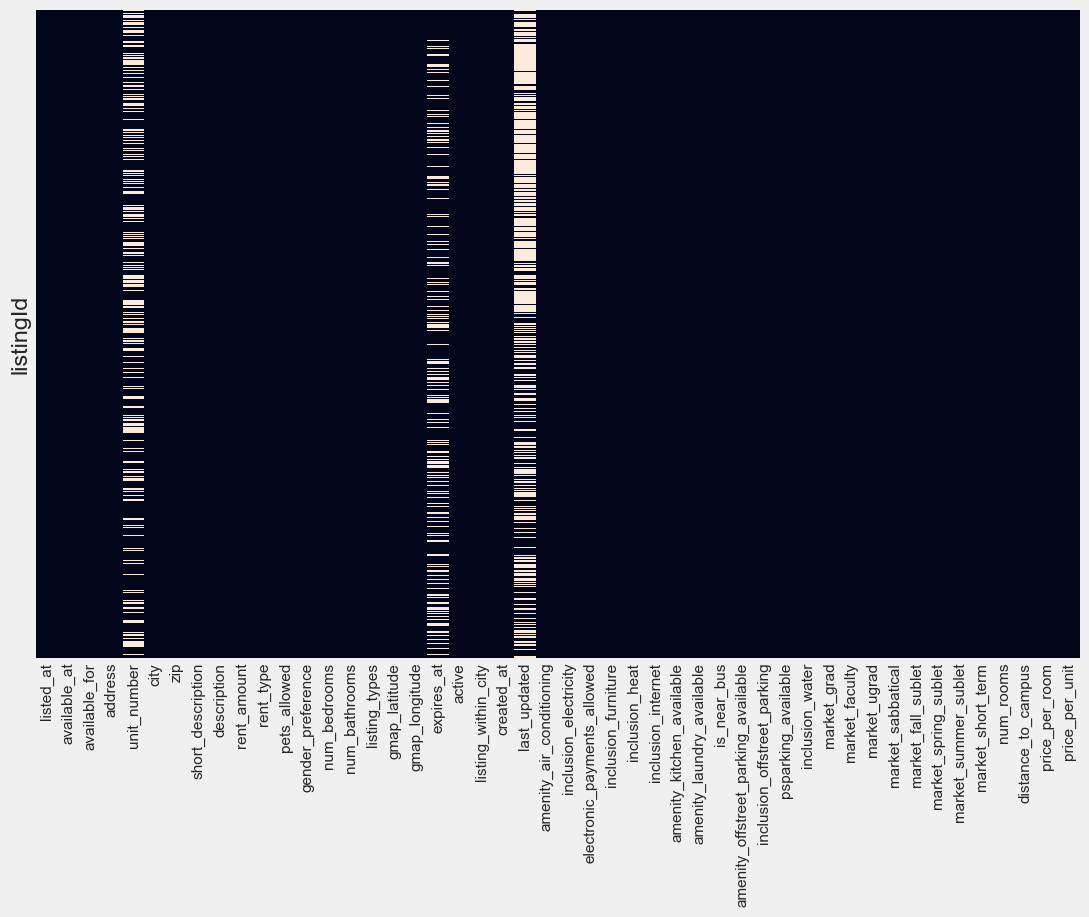

In [29]:
sns.heatmap(df.isna(), 
        yticklabels=False, 
        cbar=False)

In [30]:
def convert_meters_to_feet(value, unit_from="meters", unit_to="feet", output_type=float, prefix='', factor_power=None):
    """
    A function to convert (prefix)meters to feet of output_type
   
    param value: the measurement in (prefix)meters to convert
    type value: float
    param unit_from (optional): one of "meters", "feet". Defaults to "meters"
    type unit_from: str
    param unit_to (optional): one of "meters", "feet". Defaults to "feet"
    type unit_to: str
    param prefix (optional): a valid International System of Units metric prefix.
        (i.e. "kilo"), see wikipedia.org/wiki/Metric_prefix. Case Insensitive. Defaults to ''
    type prefix: str 
    param output_type (optional): desired output type. Defaults to float
    type output_type: one of str, int, float
    param factor_power (optional): the base 10 exponent of desired prefix. Defaults to None 
    type factor_power: int
 
    rtype: output_type 
    """
    possible_prefixes={"yotta":24,"zetta":21,"exa":18,"peta":15,"tera":12,"giga":9,"mega":6,"kilo":3,"hecto":2,"deca":1,
                       "":0,"deci":-1,"centi":-2,"milli":-3,"micro":-6,"nano":-9,"pico":-12,"femto":-15,"atto":-18,"zepto":-21,"yocto":-24}
    possible_conversion_factors = {"meters_to_feet":3.28, "feet_to_meters":0.3048, "feet_to_feet":1, "meters_to_metters":1}
    conversion_factors_key = unit_from+"_to_"+unit_to
    if factor_power is None:
        factor_power = possible_prefixes[prefix.lower()]
    value_scaled_to_meter = value*(10**factor_power)
    conversion_factor = possible_conversion_factors[conversion_factors_key]
    output = value_scaled_to_meter*conversion_factor
    return output_type(output)

In [31]:
def test_convert_meters_to_feet():
    # Tests function convert_meters_to_feet
    assert convert_meters_to_feet(0, output_type=int) == 0
    assert convert_meters_to_feet(1, output_type=float) == 3.28
    assert convert_meters_to_feet(2, output_type=int) == convert_meters_to_feet(1, output_type=int)*2
    assert convert_meters_to_feet(5, prefix="Kilo") == convert_meters_to_feet(5, factor_power=3) == convert_meters_to_feet(5000)
    assert type(convert_meters_to_feet(5, output_type=int)) is int
    assert type(convert_meters_to_feet(5, output_type=str)) is str
    assert type(convert_meters_to_feet(5, output_type=float)) is float
    
test_convert_meters_to_feet()

In [32]:
def generate_map(df=df,gmapLatitude=42.44764589643703,gmapLongitude=-76.48496728637923):
    """
    param: df
    type: pd.DataFrame() Object
    param gmapLatitude: 
    type df.gmapLatitude: float 
    param gmapLongitude: 
    type df.gmapLongitude: float
    rtype: folium.Map() Object
    """
    res = folium.folium.Map(location=[42.44764589643703,-76.48496728637923],width='100%', height='100%', left='0%', top='0%',
                     zoom_start=14,position='relative', tiles='OpenStreetMap')
    folium.vector_layers.CircleMarker([42.44764589643703, -76.48496728637923], radius=2.5, color='red', opacity=1).add_to(res)
    for index, row in df.iterrows(): 
        folium.vector_layers.CircleMarker([row["gmap_latitude"], row["gmap_longitude"]], radius=0.2, color="blue", opacity=0.5).add_to(res)
    folium.vector_layers.Circle(location=[42.44764589643703,-76.48496728637923],radius=convert_meters_to_feet(2.5,prefix="kilo", unit_from="meters",
        unit_to="feet",output_type=float),color="white").add_to(res)
    return res

In [33]:
generate_map(df)

<a id="data/variables"></a>
### 2.4. Project Variables

Using response variable:
> - rent_price (int, per person)

The project will analyze the following as potential explanatory variables:

> **dummy**
> - air_conditioning 
> - pets_allowed 
> - internet_included 
> - kitchen_available 
> - laundry_available
> - internet_included
> - near_bus
> - osparking_included 
> - osparking_available
> - psparking_available
> - electricity_included
> - heat_included
> - water_included
> - furniture_included    

> **discrete**     
> - bedrooms (number of bedrooms, 'studio' = 0)
> - bathrooms (number of bathrooms)
> - date_available         

> **continuous**     
> - distance

These are effectively just translations of the information offered by database to prospective renters. We are trying to build a releaved-preference model, and want to rely on tangible consumer choices. 

<a id="EDA"></a>
## 3. Exploratory Data Analysis
Now that we've cleaned our dataset, let's take a look at the numbers!

In [677]:
def apply_filter(df): 
    """
    """
    df = df.loc[df.market_spring_sublet == 0]
    df = df.loc[df.market_fall_sublet == 0]
    df = df.loc[df.market_summer_sublet == 0]
    df = df.loc[df.market_short_term == 0]
    df = df.loc[df.num_bedrooms <= 9]
    df = df.loc[df.price_per_unit <= 15000]
    df = df.loc[df.distance_to_campus <= 2500]
    return df 

In [700]:
df = transform(load_data())
df = apply_filter(df)
generate_map(df)

<AxesSubplot:xlabel='num_rooms', ylabel='price_per_unit'>

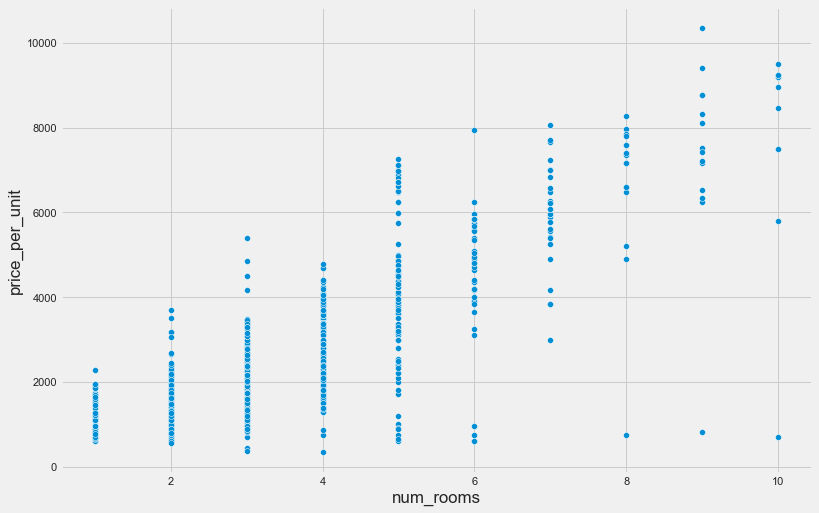

In [680]:
sns.scatterplot(data=df, x="num_rooms", y="price_per_unit")

<AxesSubplot:xlabel='num_rooms', ylabel='price_per_unit'>

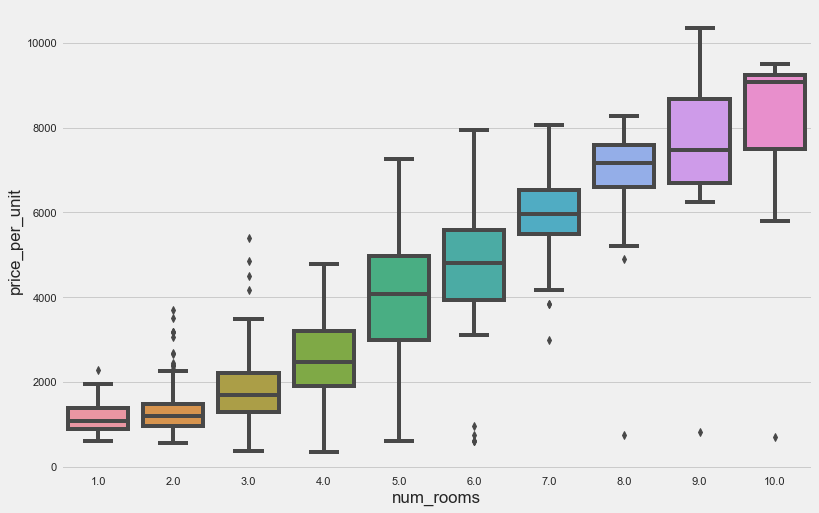

In [681]:
sns.boxplot(data=df, x="num_rooms", y="price_per_unit")

<AxesSubplot:xlabel='num_rooms', ylabel='price_per_room'>

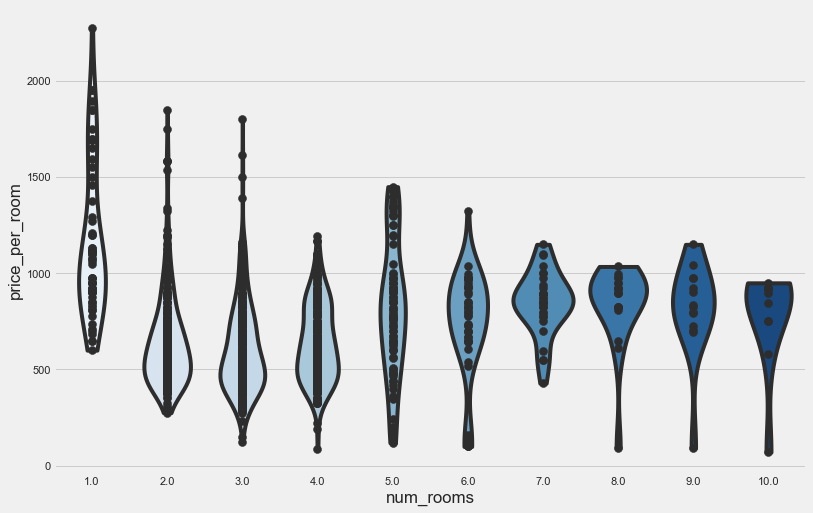

In [687]:
    sns.violinplot(data=df, x="num_rooms", y="price_per_room", inner="point", cut=0, scale="area",split=True, palette="Blues",discrete=True)

In [702]:
expensive_singles = df.loc[(df.price_per_room > 1250) & (df.num_rooms <= 2)]
generate_map(expensive_singles)

2460.0

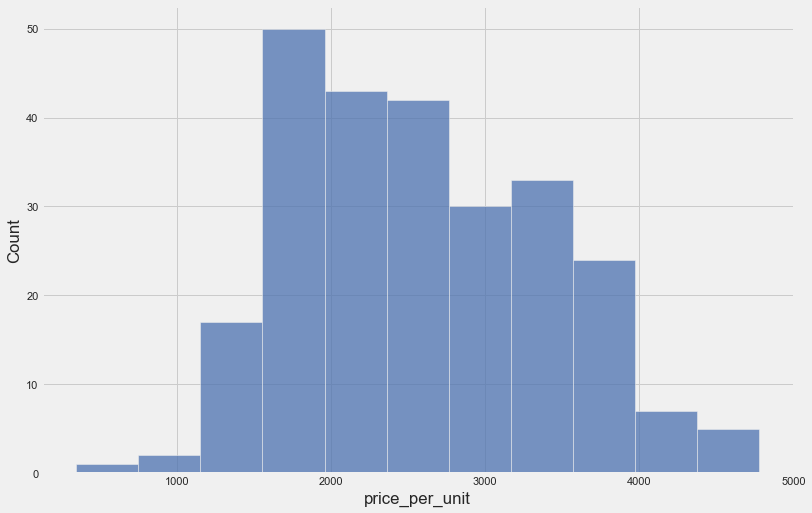

In [683]:
one_beds = df.loc[df.num_bedrooms == 3]
sns.histplot(data=one_beds, x="price_per_unit")
one_beds.price_per_unit.median()

In [684]:
df.loc[df.price_per_room <= 600].rent_type.value_counts().sort_index()
# rent_type does not appear to be a reiable column! 

Price per Person     35
Price per Unit      470
Name: rent_type, dtype: int64

<AxesSubplot:xlabel='num_bathrooms', ylabel='price_per_unit'>

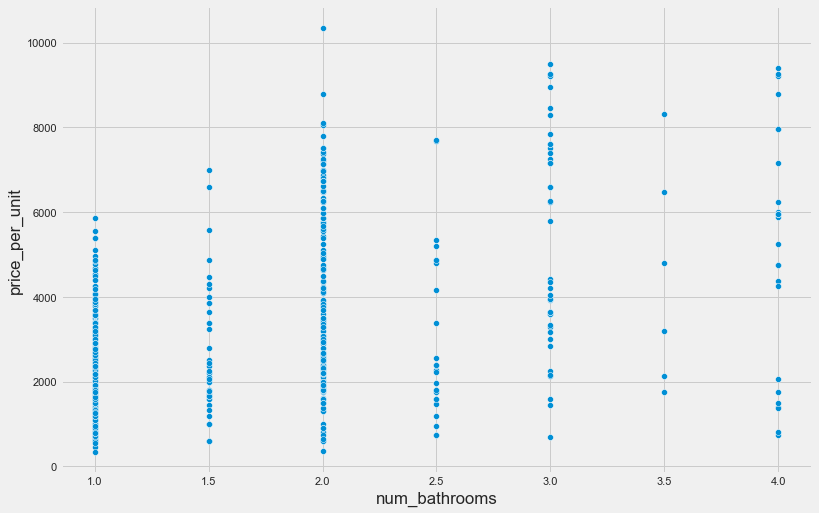

In [685]:
sns.scatterplot(data=df, x="num_bathrooms", y="price_per_unit")

In [686]:
only_grad = df.loc[(df.market_ugrad == 0) & (df.market_grad == 1)]
only_ugrad = df.loc[(df.market_ugrad == 1) & (df.market_grad == 0)]
print("only_grad price: "+str(only_grad.price_per_room.median())+"\nonly_ugrad price: "+str(only_ugrad.price_per_room.median()))

only_grad price: 550.0
only_ugrad price: 925.0


<AxesSubplot:xlabel='price_per_room', ylabel='Count'>

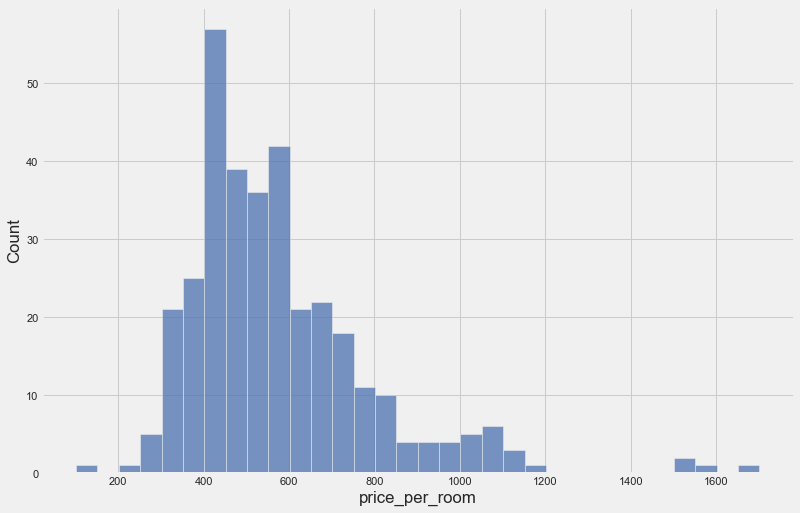

In [656]:
sns.histplot(data=only_grad, x="price_per_room",binwidth=50,stat="count")

<AxesSubplot:xlabel='price_per_room', ylabel='Count'>

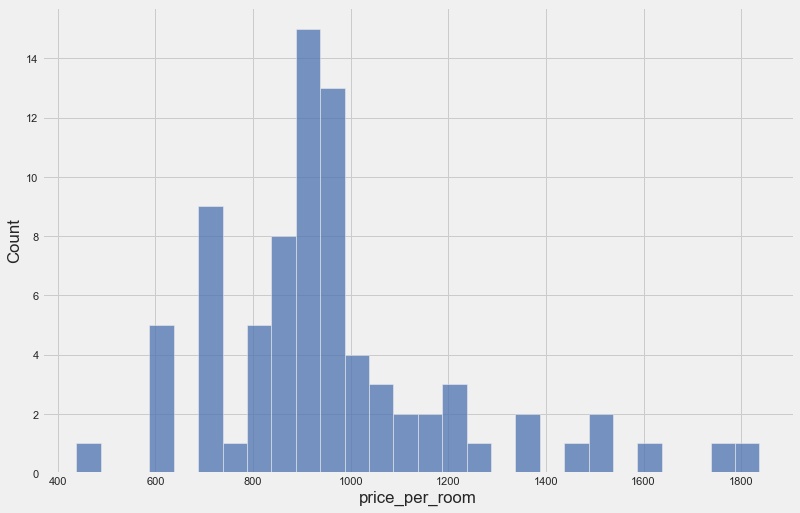

In [657]:
sns.histplot(data=only_ugrad, x="price_per_room",binwidth=50,stat="count")

Setting datatypes

<AxesSubplot:xlabel='price_per_room', ylabel='Count'>

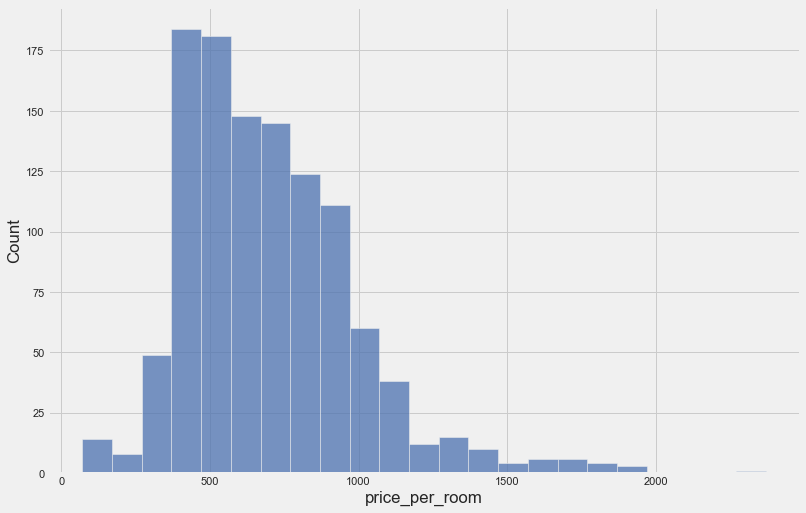

In [704]:
sns.histplot(data=df, x="price_per_room", stat="count",binwidth=100)

<AxesSubplot:xlabel='num_rooms', ylabel='Count'>

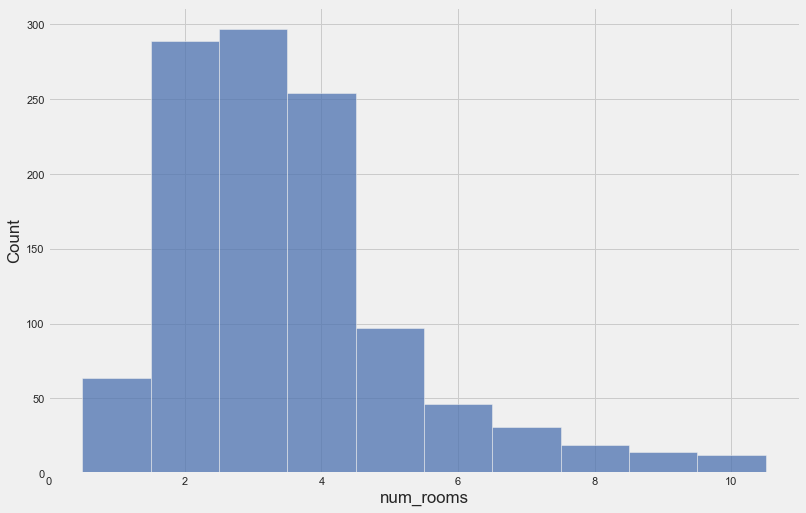

In [670]:
sns.histplot(data=df, x='num_rooms', stat="count",discrete=True)

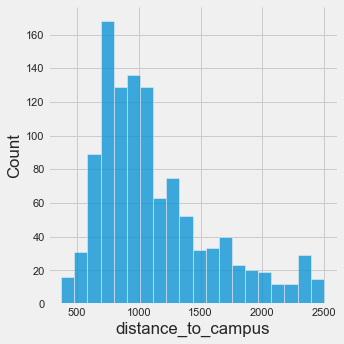

In [663]:
sns.displot(data=df, x='distance_to_campus')

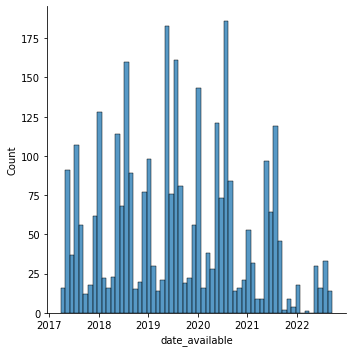

In [325]:
sns.displot(data=df, x='date_available',bins=60)

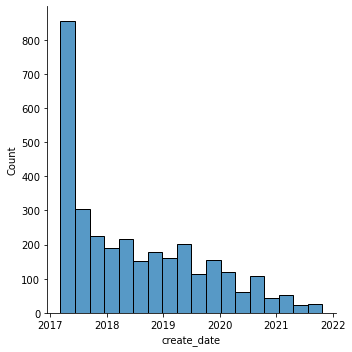

In [326]:
sns.displot(data=df, x='create_date')

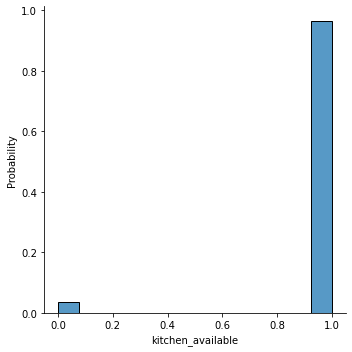

In [58]:
sns.displot(data=df, x='kitchen_available', stat="probability")

<AxesSubplot:xlabel='ugrad', ylabel='count'>

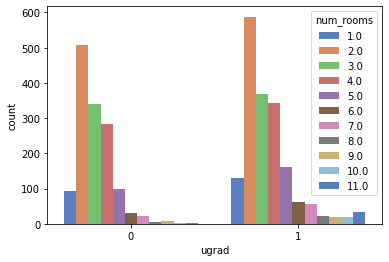

In [59]:
sns.countplot(x="ugrad", data=df, hue="num_rooms",palette="muted")

In [ ]:
sns.countplot(x="graduate", data=df, hue="num_rooms",palette="muted")

In [237]:
#sns.scatterplot(data=listings,x='air_conditioning',y='rentAmount')

In [238]:
#sns.stripplot(data=adjusted_listings, x='air_conditioning',y='logTruePrice')

In [ ]:
both = df.loc[(df.graduate == 1) & (df.ugrad == 1)]
just_ugrad = df.loc[(df.graduate == 0) & (df.ugrad == 1)]
just_grad = df.loc[(df.graduate == 1) & (df.ugrad == 0)]
print("both: "+str(len(both))+"\nugrad_only: "+str(len(just_ugrad))+"\ngrad_only: "+str(len(just_grad)))
print("sum: "+str(len(both)+len(just_ugrad)+len(just_grad)))
print("total rows: "+str(len(df)))

In [155]:
#PCA

In [ ]:
sns.displot(listings,x='rentAmount',binwidth=100)
#positive skew

<a id="EDA"></a>
### 3.1. Univariate Analysis of Rent Price

<a id="EDA/assumptions"></a>
### 3.2. Testing the Assumptions of Linear Regression
QQ plot
Homoscedasticity 


In [ ]:
# mutual independence

In [ ]:
# independent of covariates

In [ ]:
# normality

In [ ]:
# homoskedasticity

<a id="EDA/correlation"></a>
### 3.3. Correlation Analysis

In [ ]:
# price vs date

<AxesSubplot:>

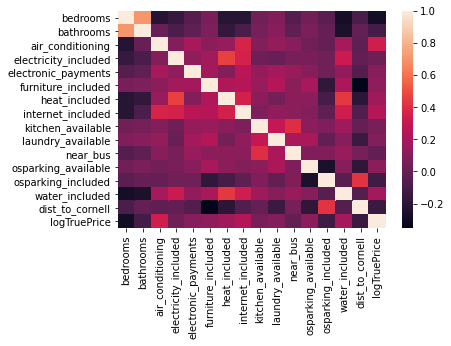

In [1422]:
seaborn.heatmap(var_corr, xticklabels=var_corr.columns, yticklabels=var_corr.columns)
#multicollinearity among amenities. Probably best to turn into an ordinal variable of 'many amenities', 'some amenities', etc. 
#also see correlation between #bed/baths. Best bet is probably to only use one. 
# we also see that none of the explanatory variables have a particulary strong correlation with price. 

<AxesSubplot:xlabel='dist_to_cornell', ylabel='logTruePrice'>

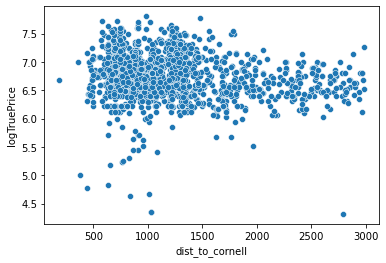

In [1444]:
seaborn.scatterplot(data=regression_vars,x='dist_to_cornell',y='logTruePrice')
# doesn't appear to be much in the way of correlation

In [1421]:
adjusted_listings.dateAvailable=pd.to_numeric(adjusted_listings.dateAvailable)
adjusted_listings.columns
regression_vars = adjusted_listings.drop(columns=['listingAddress', 'unitNumber', 'rentAmount', 'rentType', 'housingType', 'dateAvailable', 'gmapLatitude',
       'gmapLongitude', 'faculty', 'ugrad', 'sabbatical', 'fa_sublet', 'spr_sublet', 'sum_sublet', 'short_term', 'graduate', 'truePrice','logUnitPrice','pets','psparking_available'])
var_corr = regression_vars.corr()
print(var_corr)

                      bedrooms  bathrooms  air_conditioning  \
bedrooms              1.000000   0.705262         -0.217472   
bathrooms             0.705262   1.000000          0.010034   
air_conditioning     -0.217472   0.010034          1.000000   
electricity_included -0.154050  -0.087774          0.100498   
electronic_payments  -0.049927  -0.018969          0.203266   
furniture_included    0.060228   0.076363          0.124616   
heat_included        -0.210624  -0.172719          0.162868   
internet_included    -0.214578  -0.088615          0.369762   
kitchen_available     0.042824   0.054995          0.093517   
laundry_available     0.090000   0.108357          0.145780   
near_bus             -0.051170  -0.015462          0.107267   
osparking_available   0.035209   0.071383          0.039209   
osparking_included   -0.032251   0.002563         -0.002596   
water_included       -0.277763  -0.256506          0.205716   
dist_to_cornell      -0.087367  -0.000273         -0.02

<a id="modeling"></a>
## 4. Modeling  

<a id="modeling/construction"></a>
### 4.1. Model Construction

$$ y_i = w^Tx_i+\varepsilon_i $$

### Ordinary Least Squares (Maximum Likeihood Estimation)
Loss Function: $$\frac{1}{n}\sum_{i=1}^n(x^Tw-y_i)^2$$
MLE: $$\min_w \frac{1}{n}\sum_{i=1}^n(x^Tw-y_i)^2$$
Closed form optimization: $$w=(XX^T)^-1Xy^T$$ where $$X = [x_1,...,x_n]$$.y=[y_1,...,y_n]$$

### Ridge Regression (Maximum A-Priori Estimation)
Loss Function: $$\frac{1}{n}\sum_{i=1}^n(x^Tw-y_i)^2$$
MAP: $$\min_w \frac{1}{n}\sum_{i=1}^n(x^Tw-y_i)^2$$
Closed form optimization: $$w=(XX^T+\lambda I)^{-1}Xy^T$$

In [1433]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

fit = smf.ols('logTruePrice ~ bedrooms + bathrooms + dist_to_cornell+C(air_conditioning)+C(electricity_included)+C(electronic_payments)+C(furniture_included)' \
                     '+C(heat_included)+C(internet_included)+C(kitchen_available)+C(laundry_available)+C(near_bus)+C(osparking_available)+C(osparking_included)+C(water_included)',data=regression_vars).fit() 
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           logTruePrice   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     34.25
Date:                Wed, 23 Dec 2020   Prob (F-statistic):           2.01e-86
Time:                        16:11:11   Log-Likelihood:                -543.30
No. Observations:                1700   AIC:                             1119.
Df Residuals:                    1684   BIC:                             1206.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           6.6822      0.055    120.884      0.000       6.574       6.791
C(air_conditioning)[T.True]         0.1671      0.019      8.887      0.000       0.130       0.204
C(electricity_included)[T.True]    -0.0983      0.021     -4.771      0.000      -0.139      -0.058
C(electronic_payments)[T.True]      0.0082      0.017      0.470      0.638      -0.026       0.042
C(furniture_included)[T.True]       0.0193      0.022      0.875      0.382      -0.024       0.063
C(heat_included)[T.True]            0.0444      0.021      2.098      0.036       0.003       0.086
C(internet_included)[T.True]        0.0757      0.020      3.785      0.000       0.036       0.115
C(kitchen_available)[T.True]        0.0974      0.054      1.815      0.070      -0.008       0.203
C(laundry_available)[T.True]        0.0310      0.027      1.158      0.247      -0.022       0.084
C(near_bus)[T.True]                -0.1233      0.033     -3.791      0.000      -0.187      -0.060
C(osparking_available)[T.True]      0.0455      0.018      2.553      0.011       0.011       0.080
C(osparking_included)[T.True]      -0.0441      0.020     -2.246      0.025      -0.083      -0.006
C(water_included)[T.True]           0.0544      0.022      2.417      0.016       0.010       0.098
bedrooms                           -0.0667      0.007     -9.897      0.000      -0.080      -0.053
bathrooms                           0.0814      0.020      4.152      0.000       0.043       0.120
dist_to_cornell                 -6.759e-05   1.77e-05     -3.825      0.000      -0.000   -3.29e-05
==============================================================================
Omnibus:                      505.003   Durbin-Watson:                   1.803
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2728.980
Skew:                          -1.286   Prob(JB):                         0.00
Kurtosis:                       8.649   Cond. No.                     1.10e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1448]:
fit = smf.ols('logTruePrice ~ bedrooms +bathrooms + C(kitchen_available) + C(air_conditioning) +C(internet_included)+ C(near_bus)',data=regression_vars).fit() 
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           logTruePrice   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     64.89
Date:                Wed, 23 Dec 2020   Prob (F-statistic):           1.01e-72
Time:                        16:20:52   Log-Likelihood:                -593.66
No. Observations:                1700   AIC:                             1201.
Df Residuals:                    1693   BIC:                             1239.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        6.6345      0.051    130.393      0.000       6.535       6.734
C(kitchen_available)[T.True]     0.1574      0.053      2.983      0.003       0.054       0.261
C(air_conditioning)[T.True]      0.1844      0.019      9.699      0.000       0.147       0.222
C(internet_included)[T.True]     0.0890      0.018      4.817      0.000       0.053       0.125
C(near_bus)[T.True]             -0.1218      0.033     -3.705      0.000      -0.186      -0.057
bedrooms                        -0.0596      0.007     -8.764      0.000      -0.073      -0.046
bathrooms                        0.0622      0.020      3.158      0.002       0.024       0.101
==============================================================================
Omnibus:                      452.906   Durbin-Watson:                   1.764
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2191.615
Skew:                          -1.175   Prob(JB):                         0.00
Kurtosis:                       8.042   Cond. No.                         28.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<a id="modeling/construction"></a>
### 4.2. Model Selection
Min AIC
p-value

<a id="modeling/validation"></a>
### 4.3. Model Validation

<a id="conclusion"></a>
## 5. Conclusion

<a id="conclusion/findings"></a>
###  5.1. Primary Findings
Both Model 1 and Model 2 fail to account for the majority of changes in listing price. Model 1 had an associated r-squared value of 0.234, and Model 2 of 0.187.  While the method of hedonic modeling is well-established in evaluating real-estate prices, the data lifted from the Off-Campus Living listings site does not appear to yield much in the way of significant results. It does appear that the presence of a kitchen and of air conditioning has the greatest positive effects on price, and as does the number of bedrooms on price per person. While models evaluated can only reasonably account for about 20% of observed price changes, given the F-Statistics of both models, it is unlikey that they are purely the result of noise: they do not fit the data to a great extent, but rather more confidently account for a small change in price. 

This could be on part of a couple different factors. The first is that renters, and especially Cornell renters, might be more likely to be low-information buyers.   
With limited information, lack of experience in searching for houses, lack of long-term commitment in the property itself, and a busy schedule, it is not unlikely that Cornell students simply do not evaluate each listing with great scrutiny. It is also the probability that the models are missing a number of important data points. The listing site does not give customers the square footage of each listing, a normally fundamental data point in evaluating properties. The model also does not account for local attractions and points of interest. Listings near popular bars or resturants may be more attractive to buyers. 

The main lessons that can be taken as a buyer from this project are: 1. Living with friends will reduce your cost on a per person basis. 2. Air conditioning comes at a premimum, and 3. Distance to Cornell does not appear to significant affect price, so feel free to look at listings near campus. 


<a id="conclusion/improvements"></a>
### 5.2. Areas for Potential Improvement
Some potential improvements to the project:
- Using sales data instead of advertised listing data to better match student revealed preference
- Employ Principle Component Analysis to better find indicator variables.  
- Employ natural language processing (NLP) to analyze listing descriptions and find consumer preferences. 

The data in question merits more study. Some interesting studies to conduct in the futute might include:
- classificaiton research to find good deals and present information similarly to seekgreek.   
- application of more complicated machine learning methods (random forest, KNN) to find future insights.    
- more detailed study on Ithaca area real estate market as whole

<a id="references"></a>
## 6. References & Resources

- https://cornellsun.com/2020/03/06/as-students-struggle-to-find-housing-three-ilr-juniors-form-new-ithaca-tenants-union/
- https://www.ithaca.com/news/why-is-ithaca-one-of-the-least-affordable-us-cities/article_e67f68f4-cb0e-11e3-9571-001a4bcf887a.html
- https://ithacavoice.com/2017/02/cornell-maximum-capacity-pay-collegetown-rents-almost-2k/
- https://ncre.cornell.edu/what-north-campus-residential-expansion
- https://www.huduser.gov/portal/publications/pdf/CMAR_IthacaNY.pdf